# Fractional cover product for examining vegetation in Hunter region polygon

In [1]:
%matplotlib inline
import datacube
import fiona
from datacube.utils import geometry

import numpy as np

import sys
sys.path.append('10_Scripts/')
import DEADataHandling

Open the polygon for loading

In [2]:
with fiona.open('HV_big_shp/HV_big.shp','r') as hunter2:
    crs = geometry.CRS(hunter2.crs_wkt)
    print(hunter2)
    poly = geometry.Geometry(hunter2[0]['geometry'],crs=crs)
    

<open Collection 'HV_big_shp/HV_big.shp:HV_big', mode 'r' at 0x7f90c3ca53c8>


In [3]:
dc = datacube.Datacube(app='dc-FC')

In [4]:
prod = dc.list_products()

Construct an ODC query for the fractional cover product for all times we have available in the polygon (1987-present). This will load a rectange so we will have to mask it later. We use the `dask_chunks` kwarg to avoid overflowing memory

In [163]:
#construct query for the region with soil samples available
query = {
    
    'geopolygon': poly,
}

#FC = DEADataHandling.load_clearlandsat(dc,query,product='fc',masked_prop=0.0,ls7_slc_off=True,lazy_load=False)

In [7]:
np.isnan(FC.PV).all()

<xarray.DataArray 'PV' ()>
array(False)

In [17]:
lessna = FC.interpolate_na(dim='time')

In [20]:
nona = lessna.dropna(dim='time')

In [25]:
nona.resample(time='3M').interpolate('cubic').time

<xarray.DataArray 'time' (time: 5)>
array(['2018-01-31T00:00:00.000000000', '2018-04-30T00:00:00.000000000',
       '2018-07-31T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-31 2018-04-30 ... 2019-01-31

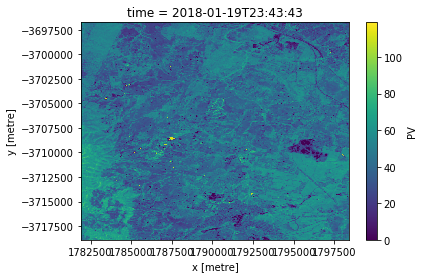

In [16]:
FC.isel(time=4).PV.plot()

In [6]:
FC = FC.chunk({'time':-1})

In [ ]:
FC.isel(time=35).PV.plot(vmin=0,vmax=100)

We can use rasterIO to construct a mask using the polygon.

In [10]:
#mask with the actual polygon
import rasterio
mask = rasterio.features.geometry_mask([poly.to_crs(FC.geobox.crs)],
                                           out_shape=FC.geobox.shape,
                                           transform=FC.geobox.affine,
                                           all_touched=False,
                                           invert=True)

FC = FC.where(mask)

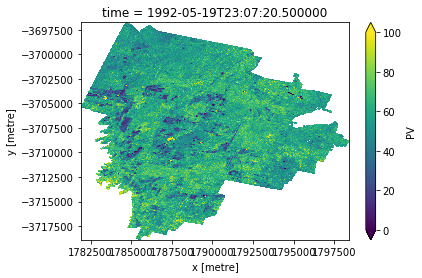

In [11]:
FC.isel(time=35).PV.plot(vmin=0,vmax=100)

In [12]:
PV_tot = FC.PV.sum(dim=['x','y'])
NPV_tot = FC.NPV.sum(dim=['x','y'])
BS_tot = FC.BS.sum(dim=['x','y'])

In [13]:
PV_prop=PV_tot/(~np.isnan(FC.PV)).sum(dim=['x','y'])

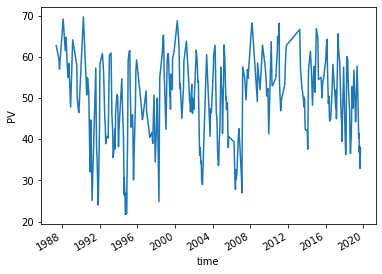

In [14]:
PV_prop.plot()

## NDVI calculation for same area

We can load the raw LS5/7/8 bands in the target region and see that the average NDVI values in the polygon line up very well with the PV % from the FC product. This is because the FC pixel percentages are heavily influenced by NDVI.

In [11]:
lsds = DEADataHandling.load_clearlandsat(dc,query,product='nbart',masked_prop=0.8)

data = lsds


mask = rasterio.features.geometry_mask([poly.to_crs(data.geobox.crs)],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)

lsds = data.where(mask)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 74 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [12]:
ndviavg = ((lsds.nir-lsds.red)/(lsds.nir+lsds.red)).mean(dim=['x','y'])

In [14]:
(PV_prop/ndviavg).mean()

<xarray.DataArray ()>
array(93.706427)

In [16]:
2*(PV_prop/ndviavg).std()

<xarray.DataArray ()>
array(7.721411)

## Annual composites of PV %

We can group the FC scenes by year, then take the maximum PV percent for each pixel to get an idea if vegetation grew in that pixel in that year (this is pretty dumb analysis, we could also do other things like an nth percentile PV for each pixel to avoid influence from outlier observations, or set a threshold and plot the percentage of time that pixel was above the threshold during the year). Visually, we can see significant variation across the period from 1987 to 2019.

In [7]:
annualPV = FC.PV.groupby('time.year')

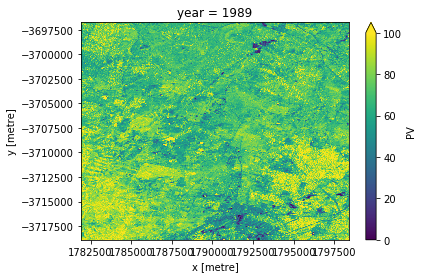

In [9]:
annualPV.max(dim='time').isel(year=2).plot(vmin=0,vmax=100)

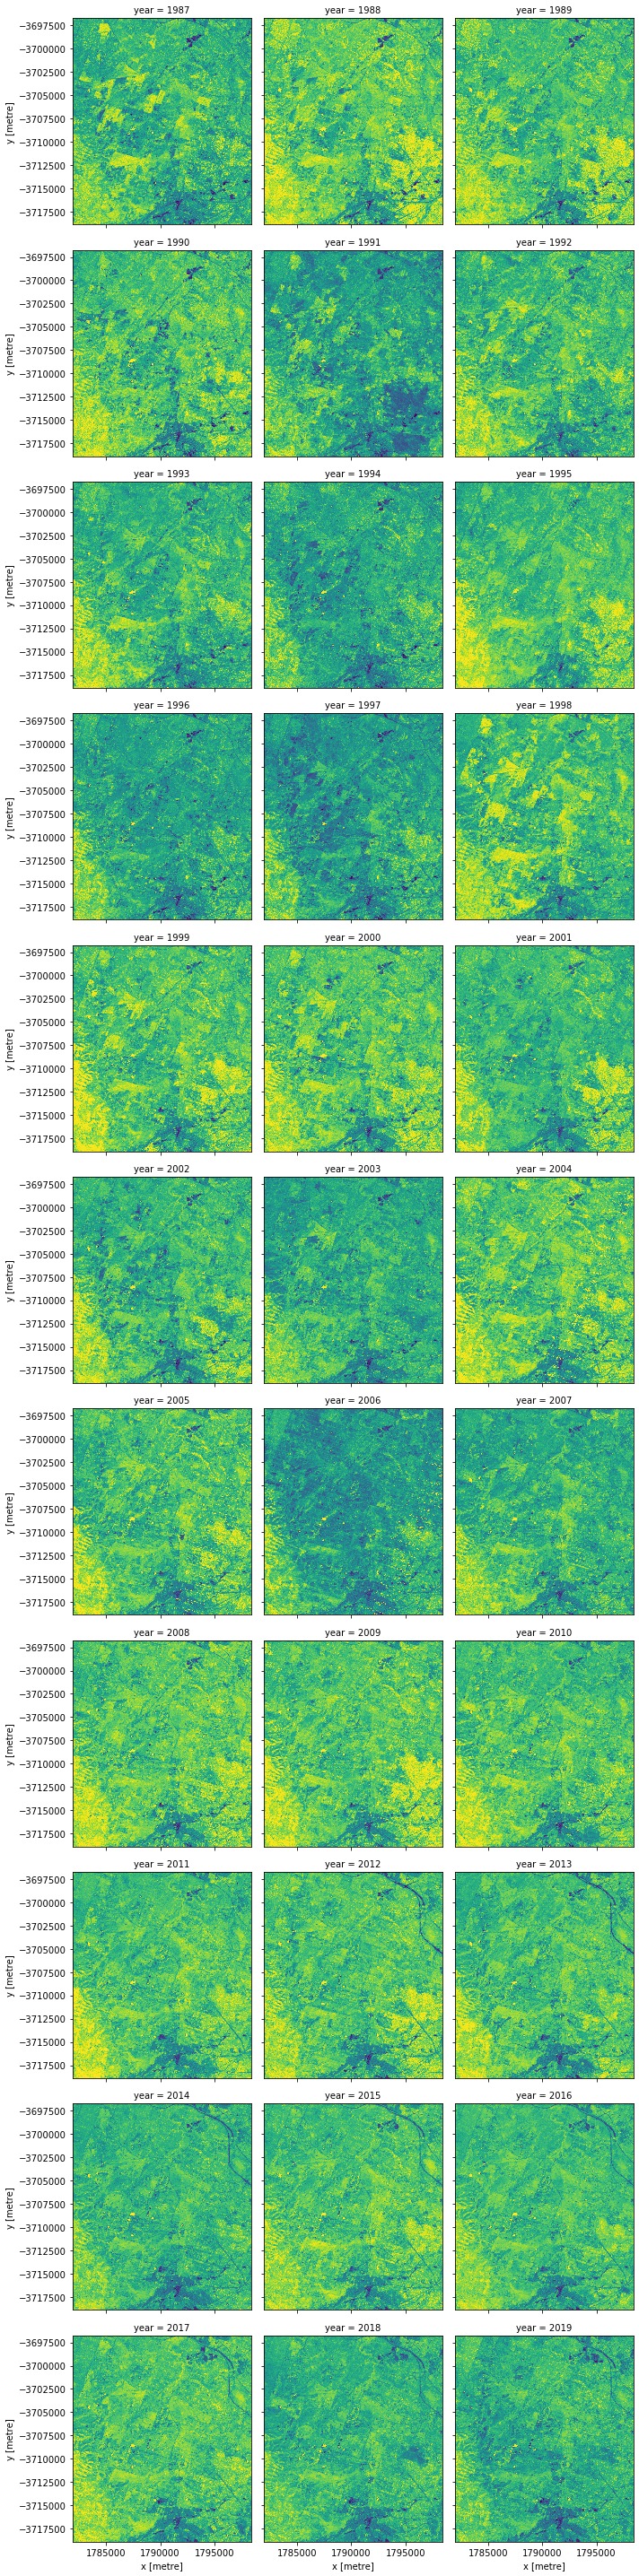

In [10]:
annualPV.max(dim='time').plot(col='year',col_wrap=3,vmin=0,vmax=100,figsize=(10,40),add_colorbar=False)

We can also compute the average maximum PV percentage across all the pixels. Again this varies quite a bit year-on-year. Also note that the values come from three different satellites (LS5 7 and 8) which *should* be processed to match each other pretty well, but this is a potential factor that may cause differences between 1987-2013 (LS5 and LS7) and 2013-present (LS8 only - DEA's default data loading methods ignore SLC-off observations from LS7).

In [11]:
PV_prop = annualPV.max(dim='time').sum(dim=['x','y'])/(~np.isnan(annualPV.max(dim='time'))).sum(dim=['x','y'])

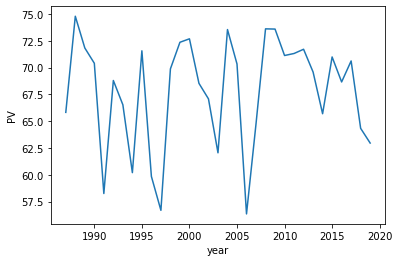

In [12]:
PV_prop.plot()

## Loading and matching ground-truth data in the region

The data was supplied as a text file. This will be opened and loaded into a pandas Dataframe for ease of doing data sciencey things with it, then the geographic coordinates will be matched to pixels from the Landsat observations.

In [6]:
import pandas as pd

In [7]:
TC_df = pd.read_csv('filtered_data.csv')

In [8]:
TC_df.columns

Index(['SampleID', 'Easting', 'Northing', 'TC', 'Method', 'Year'], dtype='object')

In [9]:
TC_crs = geometry.CRS('EPSG:32756') #WGS84 UTM zone 56S

In [ ]:
TC_df['points'] = TC_df.apply(lambda row: geometry.point(row.Easting,row.Northing,crs=TC_crs).to_crs(FC.crs),axis=1)

In [14]:
def pxts(row):
    """
    timeseries of PV% resampled to monthly.
    """
    loc = row['points']
    x = loc.coords[0][0]
    y = loc.coords[0][1]
    
    print('Getting FC timeseries for pixel near x = '+str(x)+', y = '+str(y))
    
    timeseries = FC.sel(x=x,y=y,method='nearest',tolerance=25).PV.compute()
    timeseries = timeseries.dropna(dim='time')
    if len(timeseries.time)>30:
        resamp = timeseries.resample(time='1M').interpolate('linear')
    else:
        resamp = None
    
    print('Success.')
    
    return resamp

In [ ]:
TC_df['pixel data'] = TC_df.apply(pxts,axis=1)

In [14]:
print((TC_df.Easting.max()-TC_df.Easting.min())*(TC_df.Northing.max()-TC_df.Northing.min())/25**2)

467385.5335173199


In [37]:
pvarr = example.compute()

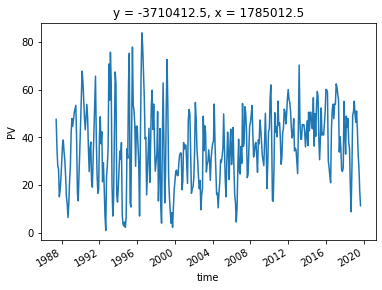

In [38]:
pvarr.plot()

In [42]:
PV_da = FC.PV

In [68]:
TC_df.apply(pxts,axis=1)

0       [<xarray.DataArray 'PV' ()>\narray(74.865707)\...
1       [<xarray.DataArray 'PV' ()>\narray(56.418962)\...
2       [<xarray.DataArray 'PV' ()>\narray(91.629795)\...
3       [<xarray.DataArray 'PV' ()>\narray(89.088922)\...
4       [<xarray.DataArray 'PV' ()>\narray(77.652074)\...
                              ...                        
2957    [<xarray.DataArray 'PV' ()>\narray(86.375132)\...
2958    [<xarray.DataArray 'PV' ()>\narray(88.437092)\...
2959    [<xarray.DataArray 'PV' ()>\narray(53.478383)\...
2960    [<xarray.DataArray 'PV' ()>\narray(71.929785)\...
2961    [<xarray.DataArray 'PV' ()>\narray(71.004911)\...
Length: 2962, dtype: object

In [77]:
import pickle
with open('FC_TC_ts.pkl','rb') as f:
    final_df = pickle.load(f)

In [78]:
final_df.head()

SampleID     Easting    Northing        TC Method  Year  \
0   2001_A1.2  338014.132  6370645.57  0.981252    CNS  2001   
1       A1MIR  338014.132  6370645.57  0.600364    MIR  2001   
2   2001_A6.2  338068.776  6370868.38  0.866419    CNS  2001   
3       A6MIR  338068.776  6370868.38  1.187051    MIR  2001   
4  2001_A11.2  338182.533  6370550.16  0.772519    CNS  2001   

                                              points  \
0  Geometry({'type': 'Point', 'coordinates': (178...   
1  Geometry({'type': 'Point', 'coordinates': (178...   
2  Geometry({'type': 'Point', 'coordinates': (178...   
3  Geometry({'type': 'Point', 'coordinates': (178...   
4  Geometry({'type': 'Point', 'coordinates': (178...   

                                       FC_timeseries  
0  [[<xarray.DataArray ()>\narray(-1.558915)\nCoo...  
1  [[<xarray.DataArray ()>\narray(-1.558915)\nCoo...  
2  [[<xarray.DataArray ()>\narray(17.85081)\nCoor...  
3  [[<xarray.DataArray ()>\narray(17.85081)\nCoor...  
4  [[<xarray.DataArray ()>\narray(14.816556)\nCoo...

In [60]:
def trunc(row):
    endyear = row['Year']
    enddate = str(endyear)+'-07-01'
    
    truncated_ts = row['FC_timeseries'].sel(time=slice('1987-01-01',enddate))
    
    return truncated_ts
    

In [80]:
final_df['Truncated_ts'] = final_df.apply(trunc,axis=1)

In [81]:
import numpy as np
lengths = np.array([len(ds.time) for ds in final_df['Truncated_ts']])
maxlength = lengths.max()

In [82]:
maxlength

109

In [83]:
final_df.head()

SampleID     Easting    Northing        TC Method  Year  \
0   2001_A1.2  338014.132  6370645.57  0.981252    CNS  2001   
1       A1MIR  338014.132  6370645.57  0.600364    MIR  2001   
2   2001_A6.2  338068.776  6370868.38  0.866419    CNS  2001   
3       A6MIR  338068.776  6370868.38  1.187051    MIR  2001   
4  2001_A11.2  338182.533  6370550.16  0.772519    CNS  2001   

                                              points  \
0  Geometry({'type': 'Point', 'coordinates': (178...   
1  Geometry({'type': 'Point', 'coordinates': (178...   
2  Geometry({'type': 'Point', 'coordinates': (178...   
3  Geometry({'type': 'Point', 'coordinates': (178...   
4  Geometry({'type': 'Point', 'coordinates': (178...   

                                       FC_timeseries  \
0  [[<xarray.DataArray ()>\narray(-1.558915)\nCoo...   
1  [[<xarray.DataArray ()>\narray(-1.558915)\nCoo...   
2  [[<xarray.DataArray ()>\narray(17.85081)\nCoor...   
3  [[<xarray.DataArray ()>\narray(17.85081)\nCoor...   
4  [[<xarray.DataArray ()>\narray(14.816556)\nCoo...   

                                        Truncated_ts  
0  [[<xarray.DataArray ()>\narray(-1.558915)\nCoo...  
1  [[<xarray.DataArray ()>\narray(-1.558915)\nCoo...  
2  [[<xarray.DataArray ()>\narray(17.85081)\nCoor...  
3  [[<xarray.DataArray ()>\narray(17.85081)\nCoor...  
4  [[<xarray.DataArray ()>\narray(14.816556)\nCoo...

In [59]:
#pad with nans to create constant-length numpy arrays, then flatten the PV and NPV together (so sklearn does the thing correctly)
def pad_n_flat(ts):
    nparr = ts.data
    padded = np.pad(nparr,((0,0),(maxlength-nparr.shape[1],0)),constant_values=np.nan).flatten()
    return padded

In [85]:
final_df['sklearn_in'] = final_df['Truncated_ts'].apply(pad_n_flat)

In [8]:
final_df['sklearn_in'][0].shape

(436,)

In [105]:
#Shuffle the data before use
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [106]:
X = final_df['sklearn_in']
y = final_df['TC']

In [107]:
len(X)

2183

In [108]:
len(y)

2183

In [109]:
#70/30 train-val split
train_X = X[0:int(0.7*len(X))]
train_y = y[0:int(0.7*len(X))]

In [110]:
#we have a bunch of nans we need to deal with in train_X, so let's do that with sklearn's imputer functions
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(np.stack(train_X))

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [111]:
np.stack(train_X).shape

(1528, 436)

In [112]:
imputed_X = imp.transform(np.stack(train_X))

In [114]:
train_y.dtype

dtype('float64')

In [145]:
#simple tree regression
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor().fit(imputed_X,train_y)

In [119]:
model

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [14]:
val_X = X[int(0.7*len(X)):]
val_y = y[int(0.7*len(X)):]

In [15]:
impval_X = imp.transform(np.stack(val_X))

In [146]:
pred_y = model.predict(impval_X)

In [148]:
#rms error
np.sqrt(((val_y-pred_y)**2).mean())

1.6068720090742292

In [149]:
val_y.mean()

2.6266420344155725

In [170]:
from sklearn.metrics import mean_squared_error, r2_score

In [151]:
mean_squared_error(model.predict(imputed_X),train_y)

0.10518822791001028

In [152]:
r2_score(model.predict(impval_X),val_y)

-0.38122668176410324

In [166]:
from sklearn.ensemble import RandomForestRegressor

bettermodel = RandomForestRegressor(n_estimators=50)

In [171]:
mean_squared_error(bettermodel.predict(X),y)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer

r2_scorer = make_scorer(r2_score)

In [118]:
Xnp = imp.transform(np.stack(X))
Xnp.shape

(2183, 436)

In [173]:
cross_val_score(bettermodel,X,y,cv=10,scoring=r2_scorer,n_jobs=8).mean()

0.122715608951886

## Principal component analysis

In [295]:
from sklearn.decomposition import PCA

In [326]:
pcX = PCA(n_components=50).fit(imp.transform(np.stack(X)))

In [333]:
pcX.components_.argmax(axis=1)%109

array([ 52,  69,  85,  81,  87,  73,  66, 108,  89,  67,  50,  91,  89,
       106, 106,  98,  79,  91,  91, 103,  89, 104,  98,  89, 103, 107,
       107,  59,  83,  81, 104,  79,  59,  87, 106,  96,  91,  91,  71,
       107, 107,  87, 106,  95,  88,  87,  73,  82,  72, 108])

In [321]:
X_pc = pcX.transform(imp.transform(np.stack(X)))

In [315]:
X_pc.shape

(2183, 10)

In [379]:
cross_val_score(othermodel,X_pc,y,cv=10,scoring=r2_scorer,n_jobs=8)

array([-0.25198294, -0.00140238, -0.09872514, -0.72264812, -0.40881304,
       -0.05454288, -0.10643147,  0.03450706, -0.35664489, -0.06912458])

In [353]:
from sklearn.neural_network import MLPRegressor

In [375]:
othermodel = MLPRegressor(hidden_layer_sizes=(100,50,25,10),max_iter = 1000,verbose=True)

In [377]:
pred_y = othermodel.predict(impval_X)

In [378]:
r2_score(pred_y,val_y)

-0.2568863367272962

In [20]:
r2_score(np.full(val_y.shape,np.mean(val_y)),val_y)

0.0

In [3]:
import qgrid

In [4]:
qgrid.show_grid(dc.list_products())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [19]:
import pickle
with open("quantile_image","rb") as f:
    img = pickle.load(f)

In [56]:
with open("FC_TC_quant.pkl","rb") as f:
    quant_df = pickle.load(f)

In [121]:
quant_df.head()

SampleID     Easting    Northing        TC Method  Year  \
0   2001_A1.2  338014.132  6370645.57  0.981252    CNS  2001   
1       A1MIR  338014.132  6370645.57  0.600364    MIR  2001   
2   2001_A6.2  338068.776  6370868.38  0.866419    CNS  2001   
3       A6MIR  338068.776  6370868.38  1.187051    MIR  2001   
4  2001_A11.2  338182.533  6370550.16  0.772519    CNS  2001   

                                              points  \
0  Geometry({'type': 'Point', 'coordinates': (178...   
1  Geometry({'type': 'Point', 'coordinates': (178...   
2  Geometry({'type': 'Point', 'coordinates': (178...   
3  Geometry({'type': 'Point', 'coordinates': (178...   
4  Geometry({'type': 'Point', 'coordinates': (178...   

                                       FC_timeseries  
0  [14.46, 25.0, 39.0, 50.0, 58.0, 67.0, 73.53999...  
1  [14.46, 25.0, 39.0, 50.0, 58.0, 67.0, 73.53999...  
2          [9.0, 16.0, 31.0, 42.0, 54.0, 68.0, 74.0]  
3          [9.0, 16.0, 31.0, 42.0, 54.0, 68.0, 74.0]  
4  [0.5299999999999994, 10.0, 25.0, 41.0, 55.0, 6...

In [2]:
import pickle
with open("FC_TC_ts.pkl","rb") as f:
    ts_df = pickle.load(f)

In [31]:
ts_df.iloc[0].FC_timeseries

<xarray.DataArray (variable: 4, time: 131)>
array([[-1.558915, 29.704605, 41.105284, ..., 24.033065, 42.047268,       nan],
       [60.803346, 63.031708, 36.445073, ..., 41.980315, 18.826087,       nan],
       [39.756622,  5.531021, 21.12935 , ..., 32.986915, 39.037608,       nan],
       [11.902413, 11.899594,  8.985943, ...,  9.005052,  6.856552,       nan]])
Coordinates:
    y         float64 -3.711e+06
    x         float64 1.785e+06
  * time      (time) datetime64[ns] 1987-05-31 1987-08-31 ... 2019-11-30
  * variable  (variable) <U3 'BS' 'PV' 'NPV' 'UE'
Attributes:
    crs:      EPSG:3577

In [ ]:
#do the preprocessing for the timeseries dataframes
ts_df['Truncated_ts'] = ts_df.apply(trunc,axis=1)
ts_df['uniform_PV_ts'] = ts_df['Truncated_ts'].apply(pad_n_flat)

In [ ]:
#impute missing values
imputed_ts = imp.fit_transform(np.stack(ts_df['uniform_PV_ts']))

ts_df['imputed_PV_ts'] = np.split(imputed_ts,len(imputed_ts))

In [ ]:
ts_df = ts_df.drop(columns=['uniform_PV_ts','Truncated_ts','FC_timeseries'])

In [ ]:
ts_df['PV_quantiles']=quant_df['FC_timeseries']

In [146]:
#save the preprocessed labelled data
with open("sklearn_covariates_hunter.pkl","wb") as f:
    pickle.dump(ts_df,f)

In [174]:
ts_df = ts_df.sample(frac=1).reset_index(drop=True)

In [177]:
ts_df.shape

(2183, 9)

In [178]:
X = np.concatenate((np.squeeze(np.stack(ts_df['imputed_PV_ts'])),np.stack(ts_df['PV_quantiles'])),axis=1)

In [179]:
X.shape

(2183, 443)

In [180]:
y = np.array(ts_df['TC'])

In [181]:
y.shape

(2183,)

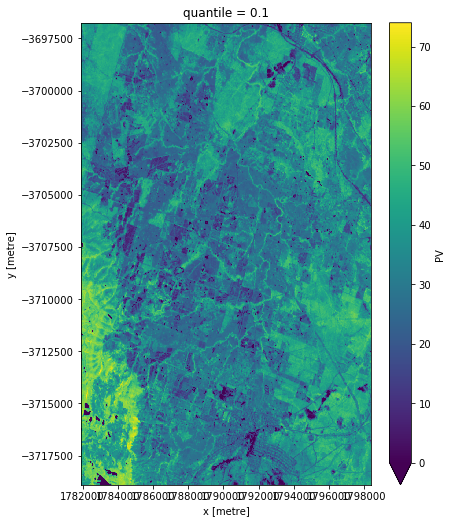

In [34]:
img.sel(quantile=0.1).plot(vmin=0,figsize=(6.5,8.5))

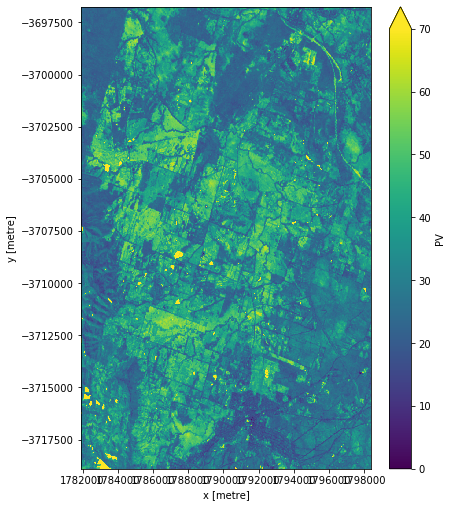

In [39]:
(img.sel(quantile=0.90)-img.sel(quantile=0.10)).plot(vmin=0,vmax=70,figsize=(6.5,8.5))

In [40]:
TC_df

NameError: name 'TC_df' is not defined

In [44]:
Xser = final_df['FC_timeseries']

In [54]:
X = np.stack(Xser)

In [51]:
y = final_df['TC']

In [55]:
X.shape

(2183, 7)

In [59]:
#dec that tree
from sklearn.tree import DecisionTreeRegressor
Xtrain = X[0:int(0.7*len(X))]
ytrain = y[0:int(0.7*len(y))]

In [60]:
treemodel = DecisionTreeRegressor().fit(Xtrain,ytrain)

In [61]:
Xval = X[int(0.7*len(X)):]
yval = y[int(0.7*len(y)):]

In [62]:
predyval = treemodel.predict(Xval)

In [64]:
predyval - yval

1528   -1.009819
1529    4.105965
1530   -1.633902
1531    0.447439
1532   -0.379476
          ...   
2178   -0.539862
2179   -1.702093
2180   -1.310107
2181    1.149058
2182   -0.761080
Name: TC, Length: 655, dtype: float64

In [65]:
from sklearn.metrics import r2_score

In [66]:
r2_score(predyval,yval)

-0.47902894055944967

In [101]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50)

In [68]:
predyval = rf_model.predict(Xval)

In [74]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
r2_scorer = make_scorer(r2_score)

In [182]:
cross_val_score(rf_model,X,y,cv=10,scoring=r2_scorer,n_jobs=8).mean()

0.3901958742912041

In [184]:
fitmodel = rf_model.fit(X,y)

In [89]:
quant_train = Xtrain
quant = X

In [86]:
#we have a bunch of nans we need to deal with in train_X, so let's do that with sklearn's imputer functions
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [87]:
ts = np.stack(final_df['sklearn_in'])
imp_ts = imp.fit_transform(ts)

ts_train = imp_ts[0:int(0.7*len(imp_ts))]

In [88]:
ts_train

array([[ 12.89409688,   6.55155106,  11.38476392, ...,  13.09846673,
         16.31253714,  10.68657787],
       [ 12.89409688,   6.55155106,  11.38476392, ...,  13.09846673,
         16.31253714,  10.68657787],
       [ 12.89409688,   6.55155106,  11.38476392, ...,  12.51852404,
         15.20357908,  12.87927577],
       ...,
       [ 12.89409688,   6.55155106,  11.38476392, ...,  17.71005804,
         13.12810139,  27.35896724],
       [ 12.89409688,   6.55155106,  11.38476392, ...,   5.12066351,
         17.80471289,  13.68732701],
       [ 12.89409688,   6.55155106,  11.38476392, ...,  20.44497139,
         12.14631332, 107.64791214]])

In [90]:
imp_ts.shape

(2183, 436)

In [91]:
quant.shape

(2183, 7)

In [96]:
X = np.concatenate((imp_ts,quant),axis=-1)

In [98]:
X.shape

(2183, 443)

In [104]:
cross_val_score(rf_model,X,y,cv=10,scoring=r2_scorer,n_jobs=8).mean()

0.11976558326155928

In [51]:
import pickle
with open("resamp_img.pkl","rb") as f:
    resamp_raster = pickle.load(f)

In [142]:
len(resamp_raster.time)

109

In [29]:
resamp_raster_arr = resamp_raster.to_array()

In [144]:
sh  = resamp_raster_arr.data.shape
resamp_raster_np = resamp_raster_arr.data.reshape(sh[0]*sh[1],sh[2],sh[3])

In [30]:
#use this if you just want to have the PV timeseries
PV_raster_np = resamp_raster_arr.data[0,:,:,:]

In [148]:
PV_raster_np.shape

(109, 886, 659)

In [308]:
mean_seasonal_FC_arr.z

<xarray.DataArray 'z' (z: 16)>
array([('BS', 'summer'), ('BS', 'winter'), ('BS', 'autumn'), ('BS', 'spring'),
       ('PV', 'summer'), ('PV', 'winter'), ('PV', 'autumn'), ('PV', 'spring'),
       ('NPV', 'summer'), ('NPV', 'winter'), ('NPV', 'autumn'),
       ('NPV', 'spring'), ('UE', 'summer'), ('UE', 'winter'), ('UE', 'autumn'),
       ('UE', 'spring')], dtype=object)
Coordinates:
  * z         (z) MultiIndex
  - variable  (z) object 'BS' 'BS' 'BS' 'BS' 'PV' ... 'NPV' 'UE' 'UE' 'UE' 'UE'
  - season    (z) object 'summer' 'winter' 'autumn' ... 'autumn' 'spring'

In [306]:
quant_raster

<xarray.DataArray 'PV' (quantile: 7, y: 886, x: 659)>
array([[[33.39, 32.4 , ..., 13.21, 17.  ],
        [36.  , 32.  , ..., 18.  , 19.  ],
        ...,
        [21.  , 22.13, ..., 27.41, 31.  ],
        [20.07, 21.17, ..., 26.35, 27.49]],

       [[48.  , 47.  , ..., 32.  , 33.  ],
        [49.  , 47.  , ..., 33.  , 35.  ],
        ...,
        [38.  , 38.  , ..., 48.  , 43.  ],
        [37.  , 37.  , ..., 49.  , 46.  ]],

       ...,

       [[69.  , 69.  , ..., 64.  , 68.  ],
        [71.  , 69.  , ..., 67.  , 69.  ],
        ...,
        [83.  , 84.  , ..., 76.  , 74.  ],
        [83.  , 82.  , ..., 77.5 , 77.  ]],

       [[76.  , 78.  , ..., 72.  , 76.  ],
        [79.61, 78.62, ..., 74.  , 78.  ],
        ...,
        [93.  , 94.  , ..., 97.53, 90.  ],
        [94.93, 93.  , ..., 91.55, 98.  ]]])
Coordinates:
  * y         (y) float64 -3.697e+06 -3.697e+06 ... -3.719e+06 -3.719e+06
  * x         (x) float64 1.782e+06 1.782e+06 1.782e+06 ... 1.798e+06 1.798e+06
  * quantile  (qua

In [298]:
with open("PV_dist_moments.pkl","wb") as f: pickle.dump(PV_stats_raster,f)

In [299]:
mean_seasonal_FC_arr = mean_seasonal_FC.to_array().stack(z=['variable','season'])

In [304]:
xr.concat((mean_seasonal_FC_arr.rename({'z':'band'}),tpi),dim='band')

<xarray.DataArray (y: 886, x: 659, band: 17)>
array([[[ 2.052051e+00,  2.556551e+00, ...,  1.704904e+01, -9.999900e+04],
        [ 4.143142e+00,  4.483781e+00, ...,  1.766833e+01, -9.999900e+04],
        ...,
        [ 2.986704e+00,  4.112853e+00, ...,  1.227957e+01, -9.999900e+04],
        [ 2.569377e+00,  4.796960e+00, ...,  1.202420e+01, -9.999900e+04]],

       [[ 4.000662e+00,  3.662699e+00, ...,  1.704099e+01, -9.999900e+04],
        [ 6.121157e+00,  5.173014e+00, ...,  1.667591e+01, -9.999900e+04],
        ...,
        [ 7.402579e+00,  7.773346e+00, ...,  1.154737e+01, -9.999900e+04],
        [ 7.757729e+00,  8.148030e+00, ...,  1.116347e+01, -9.999900e+04]],

       ...,

       [[ 4.228922e+00,  8.915880e+00, ...,  1.283349e+01, -9.999900e+04],
        [ 4.467028e+00,  7.593790e+00, ...,  1.335242e+01, -9.999900e+04],
        ...,
        [ 6.237220e+00,  7.401706e+00, ...,  1.970457e+01, -9.999900e+04],
        [ 8.833936e+00,  1.138876e+01, ...,  1.911284e+01, -9.999900e+04]

In [300]:
with open("mean_seasonal_FC.pkl","wb") as f: pickle.dump(mean_seasonal_FC_arr,f)

In [123]:
with open("quantile_img.pkl","rb") as f:
    quant_raster = pickle.load(f)

In [124]:
quant_raster

<xarray.DataArray 'PV' (quantile: 7, y: 886, x: 659)>
array([[[33.39, 32.4 , ..., 13.21, 17.  ],
        [36.  , 32.  , ..., 18.  , 19.  ],
        ...,
        [21.  , 22.13, ..., 27.41, 31.  ],
        [20.07, 21.17, ..., 26.35, 27.49]],

       [[48.  , 47.  , ..., 32.  , 33.  ],
        [49.  , 47.  , ..., 33.  , 35.  ],
        ...,
        [38.  , 38.  , ..., 48.  , 43.  ],
        [37.  , 37.  , ..., 49.  , 46.  ]],

       ...,

       [[69.  , 69.  , ..., 64.  , 68.  ],
        [71.  , 69.  , ..., 67.  , 69.  ],
        ...,
        [83.  , 84.  , ..., 76.  , 74.  ],
        [83.  , 82.  , ..., 77.5 , 77.  ]],

       [[76.  , 78.  , ..., 72.  , 76.  ],
        [79.61, 78.62, ..., 74.  , 78.  ],
        ...,
        [93.  , 94.  , ..., 97.53, 90.  ],
        [94.93, 93.  , ..., 91.55, 98.  ]]])
Coordinates:
  * y         (y) float64 -3.697e+06 -3.697e+06 ... -3.719e+06 -3.719e+06
  * x         (x) float64 1.782e+06 1.782e+06 1.782e+06 ... 1.798e+06 1.798e+06
  * quantile  (qua

In [77]:
covariate_raster_np = np.concatenate((resamp_raster_np,quant_raster.data))

In [55]:
covariate_raster_np.shape

(443, 886, 659)

In [4]:
#fit model
import pickle

with open("sklearn_covariates_hunter.pkl","rb") as f:
    sites = pickle.load(f)

In [6]:
sites = sites.sample(frac=1).reset_index(drop=True)

In [11]:
X = np.concatenate((np.squeeze(np.stack(sites['imputed_PV_ts'])),np.stack(sites['PV_quantiles'])),axis=1)

In [12]:
y = np.array(sites['TC'])

In [53]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50)

In [34]:
Xtrain = X[0:int(0.7*len(X)),:]
ytrain = y[0:int(0.7*len(y))]
rf_model.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [36]:
from sklearn.metrics import r2_score
valpred = rf_model.predict(X[int(0.7*len(X)):])
valy = y[int(0.7*len(y)):]
r2_score(valpred,valy)

-0.6958060487051605

In [54]:
from sklearn.model_selection import cross_val_score,KFold
cross_val_score(rf_model,X,y,cv=KFold(n_splits=10),n_jobs=8,scoring='r2').mean()

0.38994812181843796

In [46]:
valpred.shape

(655,)

In [47]:
valy.shape

(655,)

In [56]:
from sklearn.model_selection import train_test_split

In [63]:
Xtrain,Xval,ytrain,yval = train_test_split(X,y)

In [131]:
rf_model.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [132]:
ypred = rf_model.predict(Xval)

In [133]:
r2_score(yval,ypred)

0.36476131842142756

In [81]:
covariate_raster_np = covariate_raster_np.transpose(1,2,0)

In [83]:
sh = covariate_raster_np.shape
output = rf_model.predict(covariate_raster_np.reshape(sh[0]*sh[1],sh[2])).reshape(sh[0],sh[1])

In [84]:
output

array([[3.62899269, 3.54436966, 3.38285915, ..., 2.63856056, 2.82481897,
        2.64281274],
       [3.45978271, 3.75929236, 3.06718348, ..., 2.29918791, 2.63832857,
        2.63722543],
       [3.61706921, 3.66016888, 2.94656141, ..., 2.63329993, 2.58387408,
        2.73647184],
       ...,
       [3.86583455, 3.66311445, 3.91229175, ..., 3.9054815 , 3.66113537,
        3.41552395],
       [3.81684205, 4.08625627, 3.87960729, ..., 3.97088551, 3.63041458,
        3.61709677],
       [4.09840708, 3.99322262, 4.15157283, ..., 4.47155136, 4.211389  ,
        3.63660762]])

In [85]:
import xarray as xr

In [88]:
quant_raster.x

<xarray.DataArray 'x' (x: 659)>
array([1781937.5, 1781962.5, 1781987.5, ..., 1798337.5, 1798362.5, 1798387.5])
Coordinates:
  * x        (x) float64 1.782e+06 1.782e+06 1.782e+06 ... 1.798e+06 1.798e+06
Attributes:
    units:    metre

In [116]:
output_raster = xr.DataArray(data=output,coords={'y':quant_raster.y,'x':quant_raster.x},dims=['y','x'])

In [408]:
output_raster.plot(figsize=(6.5,8.5),robust=True)

NameError: name 'output_raster' is not defined

In [94]:
import xgboost as xgb

In [104]:
from datacube.helpers import write_geotiff

In [119]:
output_ds = xr.Dataset(data_vars={'SOC':output_raster},attrs={'crs':'EPSG:3577'})

In [120]:
write_geotiff('SOC_hunter_predicted.tiff',output_ds)

In [97]:
ts_df['TC']

0       0.981252
1       0.600364
2       0.866419
3       1.187051
4       0.772519
          ...   
2178    2.815069
2179    2.222712
2180    2.508906
2181    1.959258
2182    2.296929
Name: TC, Length: 2183, dtype: float64

In [98]:
import matplotlib.pyplot as plt

(array([  1.,   0.,   1.,   1.,   1.,   1.,   2.,   0.,   1.,   1.,   2.,
          1.,   3.,   5.,  11.,  23.,  37.,  63., 137., 200., 277., 350.,
        324., 263., 213., 127.,  86.,  33.,  13.,   6.]),
 array([-3.62315815, -3.42125394, -3.21934974, -3.01744554, -2.81554133,
        -2.61363713, -2.41173293, -2.20982873, -2.00792452, -1.80602032,
        -1.60411612, -1.40221191, -1.20030771, -0.99840351, -0.7964993 ,
        -0.5945951 , -0.3926909 , -0.1907867 ,  0.01111751,  0.21302171,
         0.41492591,  0.61683012,  0.81873432,  1.02063852,  1.22254273,
         1.42444693,  1.62635113,  1.82825534,  2.03015954,  2.23206374,
         2.43396794]),
 <a list of 30 Patch objects>)

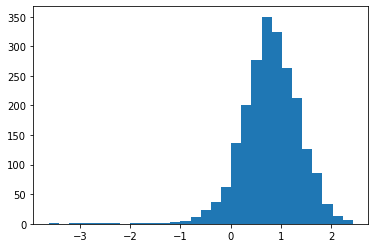

In [123]:
plt.hist(np.log(ts_df['TC']),bins=30)

In [134]:
import statsmodels

In [135]:
statsmodels

<module 'statsmodels' from '/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/statsmodels/__init__.py'>

In [138]:
from statsmodels.tsa import arima_model

In [149]:
arima_model.ARIMA()

statsmodels.tsa.arima_model.ARIMA

In [32]:
from statsmodels.tsa.stattools import acf,pacf

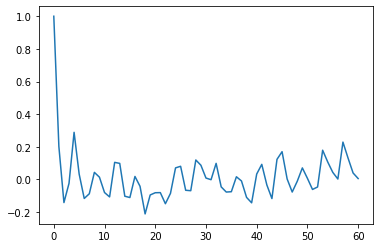

In [171]:
plt.plot(acf(PV_raster_np[:,300,300],nlags=60))

In [31]:
sh = PV_raster_np.shape
PV_np = PV_raster_np.reshape(sh[0],sh[1]*sh[2])

In [39]:
acf_arr =np.apply_along_axis(acf,0,PV_np)

In [179]:
mean_auto = np.mean(acf_arr,axis=1)

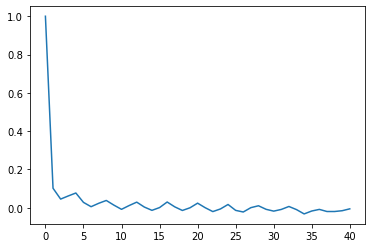

In [181]:
plt.plot(mean_auto)

It is clear that there is a seasonal pattern to the ACF, so a seasonally-adjusted ARIMA (SARIMA) may be best - depending on the PACF and other stuff

In [187]:
mean_auto[2]

0.045043630150351094

In [41]:
pacf_arr = np.apply_along_axis(pacf,0,PV_np)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-f19da9f6604e>", line 1, in <module>
    pacf_arr = np.apply_along_axis(pacf,0,PV_np)
  File "<__array_function__ internals>", line 6, in apply_along_axis
  File "/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/numpy/lib/shape_base.py", line 402, in apply_along_axis
    buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
  File "/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/statsmodels/tsa/stattools.py", line 801, in pacf
    ret = pacf_yw(x, nlags=nlags, method='unbiased')
  File "/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/statsmodels/tsa/stattools.py", line 596, in pacf_yw
    pacf.append(yule_walker(x, k, method=method)[0][-1])
  File "/g/data/v

KeyboardInterrupt: 

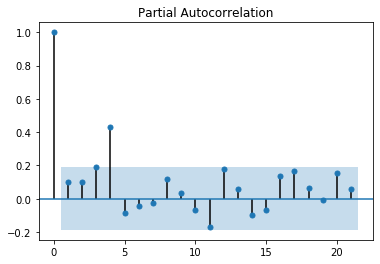

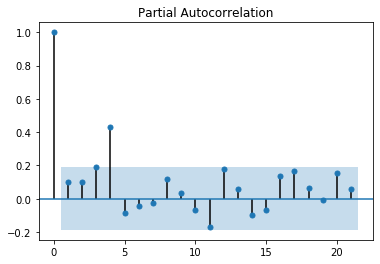

In [56]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(PV_np[:,250000])

In [190]:
PV_np.diff()

AttributeError: 'numpy.ndarray' object has no attribute 'diff'

In [ ]:
pacf(PV_np[:,30])

In [12]:
query = {
    
    'geopolygon': poly,
}

In [15]:
be_xr = dc.load(product='ls8_barest_earth_mosaic',**query)

In [16]:
be_xr.crs

CRS('EPSG:3577')

In [18]:
from datacube.helpers import write_geotiff

In [26]:
write_geotiff('barest_earth_hunter.tiff',be_xr.isel(time=0))

In [72]:
pacf_arr = pacf(PV_np[:,0],nlags=21)
pclen = len(pacf_arr)
pacf_arr = np.reshape(pacf_arr,(pclen,1))

In [73]:
for ctr in range(1,PV_np.shape[1]):
    pacf_arr = np.concatenate((pacf_arr,np.reshape(pacf(PV_np[:,ctr],nlags=21),(pclen,1))),axis=1)

In [75]:
mpacf = np.mean(pacf_arr,axis=1)

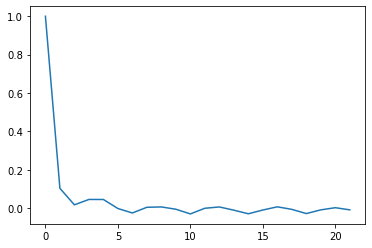

In [78]:
import matplotlib.pyplot as plt
plt.plot(mpacf)

In [80]:
mpacf

array([ 1.        ,  0.10265455,  0.0165783 ,  0.04465384,  0.0444571 ,
       -0.00263365, -0.02584076,  0.00383083,  0.00563697, -0.00630878,
       -0.03076788, -0.00129368,  0.00554405, -0.01125631, -0.0300471 ,
       -0.01043483,  0.00621138, -0.00703941, -0.02896065, -0.00964709,
        0.00165259, -0.00959295])

In [82]:
import xarray as xr
oneseven = xr.open_rasterio('SOC_geotiff/1plus7.tif')

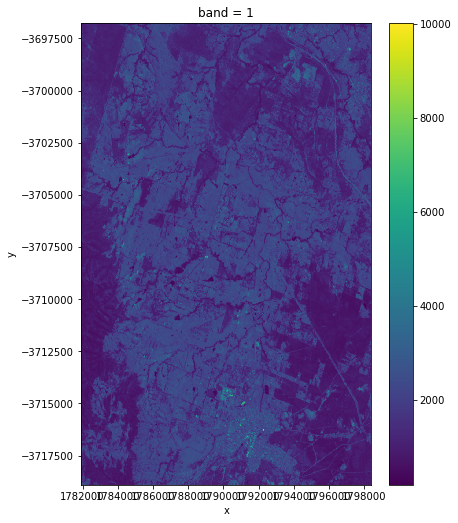

In [85]:
oneseven.plot(figsize=(6.5,8.5))

In [88]:
fivefour = xr.open_rasterio('SOC_geotiff/ratio5_4.tif')
threeone = xr.open_rasterio('SOC_geotiff/ratio3_1.tif')

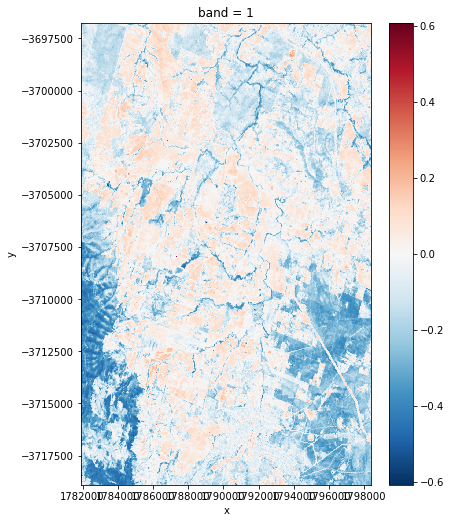

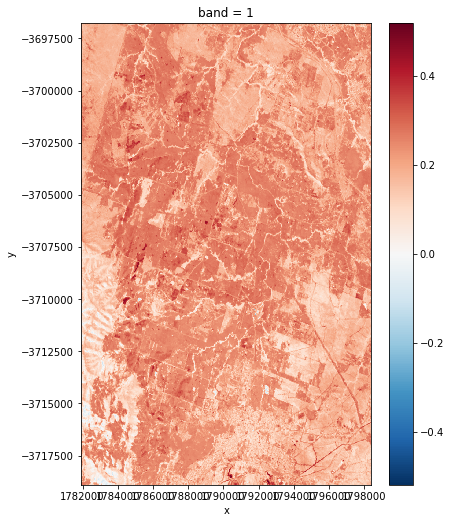

In [89]:
fivefour.plot(figsize=(6.5,8.5))
threeone.plot(figsize=(6.5,8.5))

In [90]:
threeone.x

<xarray.DataArray 'x' (x: 659)>
array([1781937.5, 1781962.5, 1781987.5, ..., 1798337.5, 1798362.5, 1798387.5])
Coordinates:
  * x        (x) float64 1.782e+06 1.782e+06 1.782e+06 ... 1.798e+06 1.798e+06

In [94]:
fivesix = xr.open_rasterio('SOC_geotiff/ratio5_6.tif')

In [6]:
import xarray as xr

In [7]:
tpi = xr.open_rasterio('SOC_geotiff/TPI_ablers.tif')

In [8]:
sagawet = xr.open_rasterio('SOC_geotiff/sagawetness_albers.tif')

In [9]:
slope = xr.open_rasterio('SOC_geotiff/slope_albers.tif')

In [10]:
aspect = xr.open_rasterio('SOC_geotiff/aspect_albers.tif')

In [11]:
mrvbf = xr.open_rasterio('SOC_geotiff/MRVBF_albers.tif')

In [120]:
static_covars = xr.concat((mrvbf,sagawet,tpi),dim='band')

In [126]:
distribution_covars = PV_stats_raster.sel(statistic=['distmean','distvar']).rename({'statistic':'band'})

In [127]:
quant_covars = quant_raster.sel(quantile=[0.01,0.1,0.25]).rename({'quantile':'band'})

In [206]:
NPV_raster = resamp_raster.NPV

In [244]:
BS_raster = resamp_raster.BS

In [271]:
PV_raster = mean_seasonal_FC.PV
NPV_raster = mean_seasonal_FC.NPV
BS_raster = mean_seasonal_FC.BS

In [273]:
all_covars = xr.concat((static_covars,distribution_covars,quant_covars,
                        PV_raster.rename({'season':'band'}),NPV_raster.rename({'season':'band'}),
                       BS_raster.rename({'season':'band'})),dim='band')

In [13]:
import pickle
with open("SARIMA.pkl","rb") as f:
    ts_coeffs = pickle.load(f)

In [14]:
ts_coeffs

<xarray.DataArray (SARIMA_coeff: 5, y: 886, x: 659)>
array([[[-8.445687e-02, -1.261838e-01, ...,  1.029991e-01,  6.558112e-03],
        [-4.235501e-02, -5.471269e-02, ...,  2.693226e-03, -3.378637e-02],
        ...,
        [ 1.052224e-01,  1.157643e-01, ..., -9.620093e-04, -7.998203e-02],
        [ 9.183058e-02,  1.168549e-01, ..., -3.969421e-03,  6.447296e-03]],

       [[-9.524907e-03,  9.961727e-03, ..., -4.159200e-02, -5.901369e-02],
        [-1.327640e-02, -1.755521e-02, ..., -4.523976e-02, -8.962617e-02],
        ...,
        [ 3.659706e-02,  1.321600e-01, ...,  1.629787e-01,  9.173923e-02],
        [ 2.779902e-01,  1.273815e-01, ...,  2.096875e-01,  1.225056e-01]],

       ...,

       [[-9.633061e-01, -9.022164e-01, ..., -9.997932e-01, -9.264316e-01],
        [-9.938140e-01, -9.940408e-01, ..., -9.994672e-01, -9.998727e-01],
        ...,
        [-9.590099e-01, -9.993168e-01, ..., -9.997925e-01, -9.998231e-01],
        [-9.997726e-01, -9.998012e-01, ..., -9.994586e-01, -9.9985

In [ ]:
quant_raster = quant_raster.rename({'quantile':'band'})

In [63]:
PV_stats_raster

<xarray.DataArray 'PV' (y: 886, x: 659, statistic: 4)>
array([[[ 5.750791e+01,  9.360067e+01, -1.606068e-01,  3.669673e-01],
        [ 5.703936e+01,  1.011107e+02, -4.823795e-01,  1.184938e+00],
        ...,
        [ 4.849375e+01,  1.949353e+02, -3.616841e-01,  5.880952e-01],
        [ 5.111001e+01,  2.157808e+02, -5.680181e-01,  8.825583e-02]],

       [[ 5.764866e+01,  1.307226e+02, -1.502620e+00,  5.218744e+00],
        [ 5.548644e+01,  1.722953e+02, -2.245466e+00,  1.051062e+01],
        ...,
        [ 5.013590e+01,  1.763831e+02, -6.288682e-01,  3.674871e-01],
        [ 5.416863e+01,  1.974259e+02, -6.477101e-01,  3.061794e-01]],

       ...,

       [[ 6.421261e+01,  2.686440e+02, -2.334895e-01, -2.690495e-01],
        [ 6.514835e+01,  2.819921e+02, -1.632036e-01, -8.284453e-02],
        ...,
        [ 6.078291e+01,  1.720123e+02, -8.038866e-04,  8.555901e-01],
        [ 5.751489e+01,  1.749450e+02,  4.621559e-01,  5.034209e-01]],

       [[ 6.464409e+01,  2.976692e+02, -2.22932

In [207]:
all_covars = xr.concat((static_covars,PV_stats_raster.rename({'statistic':'band'}),ts_coeffs.rename({'SARIMA_coeff':'band'}),
                       PV_raster.rename({'time':'band'}),NPV_raster.rename({'time':'band'})),dim='band')

In [208]:
all_covars

<xarray.DataArray (band: 230, y: 886, x: 659)>
array([[[-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        ...,
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04]],

       [[-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        ...,
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04]],

       ...,

       [[ 2.844423e+01,  2.801175e+01, ...,  2.564405e+01,  1.880219e+01],
        [ 2.594986e+01,  2.657945e+01, ...,  1.503922e+01,  1.672302e+01],
        ...,
        [ 2.182544e+01,  2.182561e+01, ...,  2.908819e+01,  3.212353e+01],
        [ 2.188395e+01,  2.070942e+01, ...,  2.899994e+01,  2.907045e+01

In [17]:
with open("FC_TC_quant.pkl","rb") as f:
    quant_df = pickle.load(f)

In [309]:
site_data_only_df = quant_df.drop(columns=['FC_timeseries'])
with open("site_and_points.pkl","wb") as f:
    pickle.dump(site_data_only_df,f)

In [18]:
train_df = quant_df.drop(columns=['FC_timeseries'])

In [162]:
def assign_weights(row):
    return 1.*(row['Method']=='CNS')+0.62*(row['Method']=='MIR')+0.43*(row['Method']=='NIR')

train_df['weights'] = train_df.apply(assign_weights,axis=1)

In [19]:
train_df.head()

SampleID     Easting    Northing        TC Method  Year  \
0   2001_A1.2  338014.132  6370645.57  0.981252    CNS  2001   
1       A1MIR  338014.132  6370645.57  0.600364    MIR  2001   
2   2001_A6.2  338068.776  6370868.38  0.866419    CNS  2001   
3       A6MIR  338068.776  6370868.38  1.187051    MIR  2001   
4  2001_A11.2  338182.533  6370550.16  0.772519    CNS  2001   

                                              points  
0  Geometry({'type': 'Point', 'coordinates': (178...  
1  Geometry({'type': 'Point', 'coordinates': (178...  
2  Geometry({'type': 'Point', 'coordinates': (178...  
3  Geometry({'type': 'Point', 'coordinates': (178...  
4  Geometry({'type': 'Point', 'coordinates': (178...

In [274]:
def select_covars(row):
    loc = row['points']
    x = loc.coords[0][0]
    y = loc.coords[0][1]
    
    covar_set = all_covars.sel(x=x,y=y,method='nearest',tolerance=25).data
    return covar_set

In [275]:
train_df['covars'] = train_df.apply(select_covars,axis=1)

In [94]:
train_df.head()

SampleID      Easting     Northing        TC Method  Year  \
0  2008_tx2_0_10  342583.0000  6366860.000  4.844000    CNS  2008   
1         d10MIR  337979.9951  6369896.481  3.485793    MIR  2004   
2       2002_B48  340792.5680  6370460.380  1.226349    CNS  2002   
3        i099MIR  342172.6130  6372390.600  0.277319    MIR  2009   
4        f147MIR  337686.0000  6372359.000  4.493171    MIR  2006   

                                              points  \
0  Geometry({'type': 'Point', 'coordinates': (178...   
1  Geometry({'type': 'Point', 'coordinates': (178...   
2  Geometry({'type': 'Point', 'coordinates': (178...   
3  Geometry({'type': 'Point', 'coordinates': (178...   
4  Geometry({'type': 'Point', 'coordinates': (178...   

                                              covars  
0  [0.19279585778713226, 82.86719512939453, 2.626...  
1  [0.04926169291138649, 173.81369018554688, 3.26...  
2  [0.5287706255912781, 29.067720413208008, 2.008...  
3  [1.0968652963638306, 347.1291198730469, 2.4224...  
4  [2.8200912475585938, 13.726414680480957, 1.781...

In [109]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [276]:
X = np.stack(train_df['covars'])

In [277]:
y = train_df['TC']

In [278]:
w = train_df['weights']

In [279]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50)

from sklearn.model_selection import cross_val_score

cross_val_score_weighted(model,X,y,w,cv=10).mean()

0.3578627523332764

In [280]:
cross_val_score(model,X,y,cv=10).mean()

0.3204622045229211

In [458]:
import xgboost as xgb

boosted_model = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.25,
                max_depth = 5, alpha = 10, n_estimators = 50)

In [459]:
cross_val_score(boosted_model,X,y,cv=10).mean()

0.30474332217304356

In [465]:
from sklearn import svm
svr_model = svm.SVR()

standardX = StandardScaler().fit_transform(X)

cross_val_score(svr_model,standardX,y,cv=10).mean()

0.21738762283921648

In [288]:
seasons = ['summer','winter','autumn','spring']
feature_names = np.array(['MRVBF','SAGA','TPI','mean','variance','q1','q10','q25',
                         *['PV'+seasons[i] for i in range(4)],
                         *['NPV'+seasons[i] for i in range(4)],
                         *['BS'+seasons[i] for i in range(4)],])

In [289]:
trainX = X[:int(0.7*len(X))]
trainy = y[:int(0.7*len(y))]
trainw = w[:int(0.7*len(w))]
valX = X[int(0.7*len(X)):]
valy = y[int(0.7*len(y)):]
valw = w[int(0.7*len(w)):]

In [290]:
model = model.fit(trainX,trainy,sample_weight=trainw)
predy = model.predict(valX)

In [291]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(valy,predy,sample_weight=valw)

0.3565175303965801

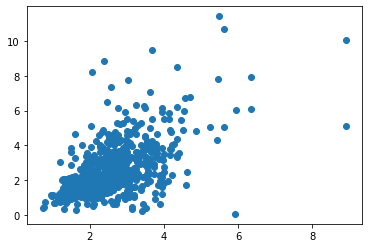

In [292]:
import matplotlib.pyplot as plt
plt.scatter(predy,valy)

In [293]:
np.sqrt(mean_squared_error(valy,predy,sample_weight=valw))

1.218431230290696

In [294]:
featimp = model.feature_importances_
err = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)/np.sqrt(len(model.estimators_))
indices = np.argsort(featimp)[::-1]

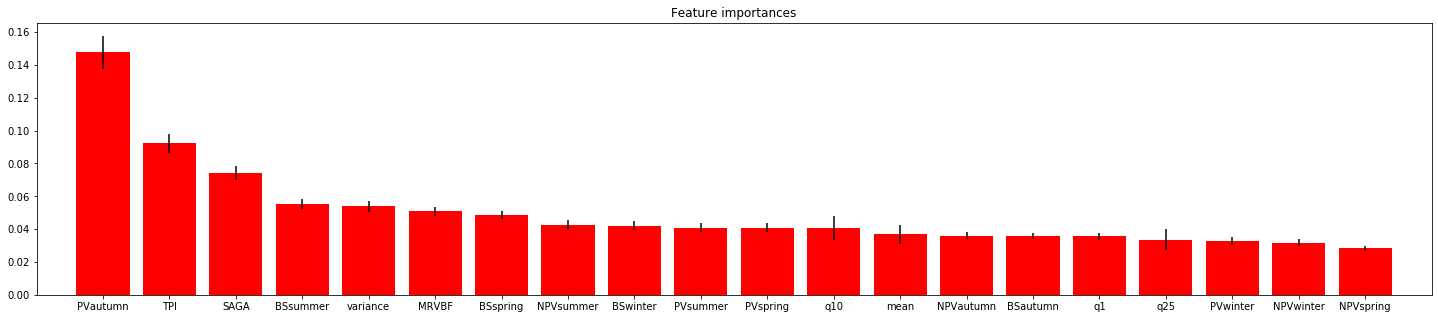

In [296]:
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), featimp[indices],
       color="r", yerr=err[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

In [261]:
feature_names[indices]

array(['q25', 'q10', 'mean', 'SAGA', 'TPI', 'PV88', 'BS2', 'MRVBF',
       'BS28', 'NPV79', 'NPV107', 'NPV44', 'BS63', 'PV75', 'PV35',
       'NPV104', 'BS6', 'BS85', 'NPV13', 'PV8', 'BS22', 'BS1', 'BS12',
       'NPV33', 'BS71', 'NPV98', 'PV1', 'NPV39', 'PV27', 'PV13', 'q1',
       'PV93', 'BS45', 'PV53', 'BS56', 'NPV71', 'NPV7', 'NPV91', 'BS92',
       'PV76', 'PV80', 'NPV19', 'BS4', 'NPV86', 'PV0', 'BS44', 'BS20',
       'NPV73', 'BS61', 'BS18', 'NPV108', 'BS51', 'BS64', 'PV104',
       'NPV65', 'BS104', 'BS48', 'BS29', 'PV39', 'PV5', 'NPV64', 'PV36',
       'PV44', 'BS82', 'PV45', 'NPV90', 'NPV14', 'NPV88', 'NPV68', 'BS14',
       'BS50', 'PV73', 'PV12', 'NPV37', 'NPV69', 'NPV89', 'PV43', 'PV82',
       'BS95', 'BS103', 'PV29', 'NPV81', 'NPV45', 'PV100', 'PV65', 'PV25',
       'BS7', 'PV63', 'NPV75', 'NPV52', 'PV59', 'NPV59', 'BS79', 'BS11',
       'BS31', 'BS81', 'PV79', 'BS106', 'BS39', 'BS60', 'NPV101', 'BS17',
       'PV9', 'PV17', 'BS76', 'PV4', 'PV71', 'BS27', 'BS24', 'BS89',

In [267]:
mean_seasonal_FC = resamp_raster.groupby('time.season').mean(dim='time')

In [269]:
mean_seasonal_FC.coords['season'] = ['summer','winter','autumn','spring']

In [270]:
mean_seasonal_FC

<xarray.Dataset>
Dimensions:  (season: 4, x: 659, y: 886)
Coordinates:
  * y        (y) float64 -3.697e+06 -3.697e+06 ... -3.719e+06 -3.719e+06
  * x        (x) float64 1.782e+06 1.782e+06 1.782e+06 ... 1.798e+06 1.798e+06
  * season   (season) <U6 'summer' 'winter' 'autumn' 'spring'
Data variables:
    BS       (season, y, x) float64 2.052 4.143 7.014 ... 7.173 6.782 9.369
    PV       (season, y, x) float64 61.97 59.69 57.89 ... 55.09 54.46 51.89
    NPV      (season, y, x) float64 34.92 34.91 34.03 36.3 ... 36.26 37.36 37.47
    UE       (season, y, x) float64 18.37 19.17 19.58 ... 20.45 19.82 19.73

In [202]:
feature_names[indices]

array(['q25', 'TPI', 'MRVBF', 'SAGA wetness', 'r31', 'q10', 'aspect',
       'r54', 'slope', 'r56', '1+7', 'q1', 'q99', 'q75', 'q50', 'q90'],
      dtype='<U12')

In [57]:
import scipy.stats

In [221]:
#load three-monthly observations
with open("resamp_img.pkl","rb") as f:
    resamp_raster = pickle.load(f)

In [55]:
PV_raster = resamp_raster.PV

In [226]:
scipy.stats.describe(PV_raster.isel(x=0,y=0)).variance

93.60066802169197

In [52]:
def desc_array(arr,**kwargs):
    desc = scipy.stats.describe(arr,**kwargs)
    return np.array([desc.mean,desc.variance,desc.skewness,desc.kurtosis])

uf_desc_array = np.vectorize(desc_array,signature='(n)->(4)')

In [236]:
np.version.version

'1.17.0'

In [58]:
PV_stats_raster = xr.apply_ufunc(uf_desc_array,PV_raster,input_core_dims=[['time']],output_core_dims=[['statistic']])

In [258]:
all_covars

<xarray.DataArray (band: 16, y: 886, x: 659)>
array([[[-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        ...,
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04]],

       [[-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38],
        ...,
        [-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38]],

       ...,

       [[ 6.900000e+01,  6.900000e+01, ...,  6.400000e+01,  6.800000e+01],
        [ 7.100000e+01,  6.900000e+01, ...,  6.700000e+01,  6.900000e+01],
        ...,
        [ 8.300000e+01,  8.400000e+01, ...,  7.600000e+01,  7.400000e+01],
        [ 8.300000e+01,  8.200000e+01, ...,  7.750000e+01,  7.700000e+01]

In [64]:
PV_stats_raster.coords['statistic']=['distmean','distvar','distskew','distkurt']

In [507]:
all_covars = xr.concat((all_covars,temp_raster),dim='band')

In [271]:
all_covars

<xarray.DataArray (band: 20, y: 886, x: 659)>
array([[[-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        ...,
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04],
        [-9.999900e+04, -9.999900e+04, ..., -9.999900e+04, -9.999900e+04]],

       [[-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38],
        ...,
        [-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38],
        [-3.402823e+38, -3.402823e+38, ..., -3.402823e+38, -3.402823e+38]],

       ...,

       [[-1.606068e-01, -4.823795e-01, ..., -3.616841e-01, -5.680181e-01],
        [-1.502620e+00, -2.245466e+00, ..., -6.288682e-01, -6.477101e-01],
        ...,
        [-2.334895e-01, -1.632036e-01, ..., -8.038866e-04,  4.621559e-01],
        [-2.229322e-01, -2.893743e-01, ..., -1.997010e-01, -1.747610e-01]

In [344]:
sh = PV_raster.data.shape
PV_flat = PV_raster.data.reshape(sh[0],sh[1]*sh[2]).transpose()

In [345]:
PV_flat.shape

(583874, 109)

In [53]:
FC_arr = resamp_raster[['BS','PV','NPV']].to_array().stack(z=['variable','time']).data

In [54]:
sh = FC_arr.shape
FC_flat = FC_arr.reshape(sh[0]*sh[1],sh[2])
FC_flat.shape

(583874, 327)

In [493]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
standardFC = StandardScaler().fit_transform(FC_flat)

In [532]:
PC_FC = PCA(n_components=5).fit_transform(standardFC)

In [533]:
PC_FC = PC_FC.reshape(sh[0],sh[1],PC_FC.shape[1])

In [535]:
PC_FC_raster = xr.DataArray(PC_FC,dims=['y','x','PC'],coords={'y':resamp_raster.y,'x':resamp_raster.x,'PC':np.arange(5)})

In [536]:
all_covars = xr.concat((static_covars,PC_FC_raster.rename({'PC':'band'})),dim='band')

In [501]:
all_covars.shape

(19, 886, 659)

In [54]:
#K-fold cross-validation supporting sample weights (from https://github.com/scikit-learn/scikit-learn/issues/4632#issuecomment-393945555)

from sklearn.model_selection import KFold
import sklearn.metrics

def cross_val_score_weighted(model, X, y, weights, cv=5, metric=sklearn.metrics.r2_score):
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        model_clone = sklearn.base.clone(model)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        weights_train, weights_test = weights[train_index], weights[test_index]
        model_clone.fit(X_train,y_train,sample_weight=weights_train)
        y_pred = model_clone.predict(X_test)
        score = metric(y_test, y_pred, sample_weight = weights_test)
        scores.append(score)
    return np.array(scores)

In [186]:
PV_raster

<xarray.DataArray 'PV' (time: 109, y: 886, x: 659)>
array([[[61.406348, 75.39601 , ..., 49.142915, 50.473764],
        [73.559857, 69.900123, ..., 58.184164, 62.189898],
        ...,
        [82.163631, 81.118074, ..., 71.309554, 92.5795  ],
        [82.854197, 70.129592, ..., 76.357413, 70.149624]],

       [[66.738922, 67.937523, ..., 51.424589, 56.720166],
        [64.953182, 67.980092, ..., 58.08471 , 57.134023],
        ...,
        [72.460889, 66.541225, ..., 63.661205, 54.50525 ],
        [63.606329, 74.495498, ..., 57.393394, 58.779099]],

       ...,

       [[68.579714, 65.641214, ..., 67.237323, 76.118794],
        [69.641298, 69.641174, ..., 75.881725, 74.277   ],
        ...,
        [73.349051, 72.349035, ..., 67.858883, 63.84124 ],
        [71.406903, 68.639602, ..., 68.035349, 66.876588]],

       [[59.420264, 60.000878, ..., 59.301891, 67.886676],
        [59.418832, 62.916419, ..., 64.94075 , 68.85122 ],
        ...,
        [50.561732, 52.102059, ..., 77.080186, 64.1

## Recursive feature elimination

In [387]:
#load covariate rasters
#topographic indices, PV timeseries distribution properties and quantiles,
#averages for seasons for each fractional cover property over all LS obs years

tpi = xr.open_rasterio('SOC_geotiff/TPI_ablers.tif')
sagawet = xr.open_rasterio('SOC_geotiff/sagawetness_albers.tif')
slope = xr.open_rasterio('SOC_geotiff/slope_albers.tif')
aspect = xr.open_rasterio('SOC_geotiff/aspect_albers.tif')
mrvbf = xr.open_rasterio('SOC_geotiff/MRVBF_albers.tif')

with open("PV_dist_moments.pkl","rb") as f:
    PV_stats_raster = pickle.load(f)
PV_stats_raster = PV_stats_raster.rename({'statistic':'band'})

with open("quantile_img.pkl","rb") as f:
    quant_raster = pickle.load(f)
quant_raster = quant_raster.rename({'quantile':'band'})
    
with open("mean_seasonal_FC.pkl","rb") as f:
    mean_seasonal_FC = pickle.load(f)
mean_seasonal_FC = mean_seasonal_FC.rename({'z':'band'})

all_covars = xr.concat((tpi,sagawet,slope,aspect,mrvbf,PV_stats_raster,quant_raster,mean_seasonal_FC),dim='band')

#drop the unmixing error
all_covars = all_covars.isel(band=slice(0,-4))

feature_names = np.array([
    'TPI',
    'SAGA wetness',
    'slope',
    'aspect',
    'MRVBF',
    'PV mean',
    'PV variance',
    'PV skewness',
    'PV kurtosis',
    'PV 1 percentile',
    'PV 10 percentile',
    'PV 25 percentile',
    'PV 50 percentile',
    'PV 75 percentile',
    'PV 90 percentile',
    'PV 99 percentile',
    'BS summer',
    'BS winter',
    'BS autumn',
    'BS spring',
    'PV summer',
    'PV winter',
    'PV autumn',
    'PV spring',
    'NPV summer',
    'NPV winter',
    'NPV autumn',
    'NPV spring',
    'UE summer',
    'UE winter',
    'UE autumn',
    'UE spring'
                         ])

#clip and prepare covariates to match site data

with open("site_and_points.pkl","rb") as f:
    site_data = pickle.load(f)
    
def select_covars(row):
    loc = row['points']
    x = loc.coords[0][0]
    y = loc.coords[0][1]
    
    covar_set = all_covars.sel(x=x,y=y,method='nearest',tolerance=25).data
    return covar_set

site_data['covars'] = site_data.apply(select_covars,axis=1)

#shuffle the dataframe to avoid bias in training set

site_data = site_data.sample(frac=1).reset_index(drop=True)

X = np.stack(site_data['covars'])
y = site_data['TC']

#partition out a test set. This set will not be seen at all during feature selection.
testX = X[int(0.8*len(X)):]
testy = y[int(0.8*len(y)):]

#make the 'training set' available for feature selection and CV
X = X[:int(0.8*len(X))]
y = y[:int(0.8*len(y))]

In [390]:
model = RandomForestRegressor(n_estimators = 50)

In [391]:
from sklearn.feature_selection import RFECV

In [406]:
selector = RFECV(model,n_jobs=-1,cv=25)

In [407]:
selector = selector.fit(X,y)

In [409]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [410]:
feature_names = np.array([
    'TPI',
    'SAGA wetness',
    'slope',
    'aspect',
    'MRVBF',
    'PV mean',
    'PV variance',
    'PV skewness',
    'PV kurtosis',
    'PV 1 percentile',
    'PV 10 percentile',
    'PV 25 percentile',
    'PV 50 percentile',
    'PV 75 percentile',
    'PV 90 percentile',
    'PV 99 percentile',
    'BS summer',
    'BS winter',
    'BS autumn',
    'BS spring',
    'PV summer',
    'PV winter',
    'PV autumn',
    'PV spring',
    'NPV summer',
    'NPV winter',
    'NPV autumn',
    'NPV spring',
                         ])

In [411]:
feature_names[selector.support_]

array(['TPI', 'SAGA wetness', 'slope', 'aspect', 'MRVBF', 'PV mean',
       'PV variance', 'PV skewness', 'PV kurtosis', 'PV 1 percentile',
       'PV 10 percentile', 'PV 25 percentile', 'PV 50 percentile',
       'PV 75 percentile', 'PV 90 percentile', 'PV 99 percentile',
       'BS summer', 'BS winter', 'BS autumn', 'BS spring', 'PV summer',
       'PV winter', 'PV autumn', 'PV spring', 'NPV summer', 'NPV winter',
       'NPV autumn', 'NPV spring'], dtype='<U16')

In [412]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

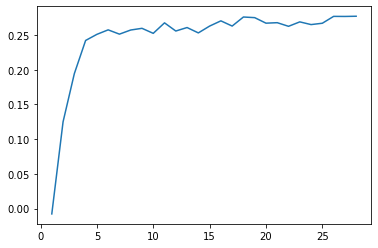

In [413]:
plt.plot(range(1,len(selector.grid_scores_)+1),selector.grid_scores_)

In [414]:
culledX = X[:,selector.support_]

In [415]:
model.fit(culledX,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [416]:
predy=model.predict(testX[:,selector.support_])

In [417]:
r2_score(testy,predy)

0.3104939735008526

In [418]:
cross_val_score(model,culledX,y,cv=10,n_jobs=-1).mean()

0.28915687627174547

## Comparison with covariates from CNN paper

In [1]:
import xarray as xr
import pickle

In [2]:
bareEarth = xr.open_rasterio('SOC_geotiff/Hunter_30Bare94.tif')
bareEarthRGB = xr.Dataset({'red':bareEarth.sel(band=3,drop=True),'green':bareEarth.sel(band=2,drop=True),'blue':bareEarth.sel(band=1,drop=True)})

In [3]:
bareNDVI = (bareEarth.sel(band=4,drop=True)-bareEarth.sel(band=3,drop=True))/(bareEarth.sel(band=4,drop=True)+bareEarth.sel(band=3,drop=True))

In [4]:
#with open("NDVI_hunt.pkl","rb") as f:
#    ndvi = pickle.load(f)
ndvi = (bareEarth.sel(band=4,drop=True)-bareEarth.sel(band=3,drop=True))/(bareEarth.sel(band=4,drop=True)+bareEarth.sel(band=3,drop=True))

In [5]:
#with open("swir1_hunt.pkl","rb") as f:
#    band5 = pickle.load(f)
band5 = bareEarth.sel(band=5,drop=True)

In [6]:
dem = xr.open_rasterio("SOC_geotiff/dem_fill_albers.tif")

In [13]:
dem

<xarray.DataArray (band: 1, y: 886, x: 659)>
[583874 values with dtype=float64]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -3.697e+06 -3.697e+06 ... -3.719e+06 -3.719e+06
  * x        (x) float64 1.782e+06 1.782e+06 1.782e+06 ... 1.798e+06 1.798e+06
Attributes:
    transform:   (25.0, 0.0, 1781925.0, 0.0, -25.0, -3696750.0)
    crs:         +init=epsg:3577
    res:         (25.0, 25.0)
    is_tiled:    0
    nodatavals:  (-1.7e+308,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [7]:
band5 = band5.expand_dims('time').rename({'time':'band'}).assign_coords(band=[2])

In [8]:
ndvi = ndvi.expand_dims('time').rename({'time':'band'}).assign_coords(band=[3])

In [9]:
#all points should be at or above sea level
dem = dem.where(dem >= 0)

In [51]:
all_covars = xr.concat((dem,ndvi,band5,),dim='band')

In [52]:
all_covars

<xarray.DataArray (band: 3, y: 886, x: 659)>
array([[[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[5.936073e-01, 6.103997e-01, ..., 4.652972e-01, 4.833993e-01],
        [6.157895e-01, 6.047674e-01, ..., 4.924855e-01, 5.092958e-01],
        ...,
        [5.474818e-01, 5.493658e-01, ..., 6.516715e-01, 6.211154e-01],
        [5.397784e-01, 5.374016e-01, ..., 6.581818e-01, 6.427977e-01]],

       [[1.723000e+03, 1.583000e+03, ..., 2.875000e+03, 2.902000e+03],
        [1.639000e+03, 1.652000e+03, ..., 2.882000e+03, 2.923000e+03],
        ...,
        [2.768000e+03, 2.773000e+03, ..., 1.254000e+03, 1.289000e+03],
        [2.793000e+03, 2.794000e+03, ..., 1.285000e+03, 1.257000e+03]]])
Coordinates:
  * y        (y) float64 -3.697e+06 -3.697e+0

In [186]:
#clip and prepare covariates to match site data

with open("site_and_points.pkl","rb") as f:
    site_data = pickle.load(f)
    
def select_covars(row):
    loc = row['points']
    x = loc.coords[0][0]
    y = loc.coords[0][1]
    
    covar_set = all_covars.sel(x=x,y=y,method='nearest',tolerance=25).data
    return covar_set

def assign_weights(row):
    return 1.*(row['Method']=='CNS')+0.62*(row['Method']=='MIR')+0.43*(row['Method']=='NIR')

site_data['covars'] = site_data.apply(select_covars,axis=1)
site_data['weights'] = site_data.apply(assign_weights,axis=1)

#shuffle the dataframe to avoid bias in training set

site_data = site_data.sample(frac=1).reset_index(drop=True)

X = np.stack(site_data['covars'])
y = site_data['TC']
w = site_data['weights']


from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan,strategy='mean')
X = imp.fit_transform(X)

#standardise inputs
#from sklearn.preprocessing import StandardScaler
#scal = StandardScaler()
#X = scal.fit_transform(X)

#partition out a test set. This set will not be seen at all during feature selection.
testX = X[int(0.8*len(X)):]
testy = y[int(0.8*len(y)):]
testw = w[int(0.8*len(w)):]

#make only the 'training set' available for feature selection and CV
X = X[:int(0.8*len(X))]
y = y[:int(0.8*len(y))]
w = w[:int(0.8*len(w))]

#gaussianise the training inputs
from sklearn.preprocessing import PowerTransformer
tr = PowerTransformer(method='box-cox',standardize=True)
X = tr.fit_transform(X)
#apply the same transformation (without fitting it) to the test set
testX = tr.transform(testX)




In [200]:
#pipeline the RF with a linear model to 'fix' the biased predictions of the RF
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000,criterion='mse')

In [188]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score_weighted(model,X,y,w,cv=10)
[cvs.mean(),cvs.std()]

[0.31228478754487743, 0.0621343020680418]

In [189]:
cvs

array([0.34523121, 0.34571281, 0.25771302, 0.38508565, 0.30149824,
       0.18714547, 0.3749583 , 0.37375831, 0.30742311, 0.24432175])

In [197]:
model.fit(X,y,sample_weight=w)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [191]:
predy = model.predict(testX)

In [192]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(testy,predy,sample_weight=testw))
print(np.sqrt(mean_squared_error(testy,predy,sample_weight=testw)))

errs = predy-testy
print(np.average(errs,weights=testw))


0.3854233181912934
1.0793102292888805
0.053704804596825376


In [99]:
#test stacking regressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, cross_val_predict
est1 = SVR()

cvSVR = cross_validate(est1,X,y,return_estimator=True,cv=5)

trainSVR = cross_val_predict(est1,X,y,cv=5)

def cvpred(X):
    preds = [estimator.predict(X) for estimator in cvSVR['estimator']]
    return np.mean(preds,axis=0)

#stack the SVR predictions onto the covariates
augX = np.concatenate((X,np.reshape(trainSVR,(*trainSVR.shape,1))),axis=1)

In [100]:
#fit the random forest on the augmented inputs and then test the new R2 score
model.fit(augX,y,sample_weight=w)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=8000, n_jobs=8,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [101]:
augtestX = np.concatenate((testX,np.reshape(cvpred(testX),(*cvpred(testX).shape,1))),axis=1)

predy = model.predict(augtestX)
r2_score(testy,predy,sample_weight=testw)

0.29916634850907575

## TS of the exact same covariate set budi used

In [22]:
with open("swirndvi.pkl","rb") as f:
    ts_covars = pickle.load(f)

In [23]:
ts_covars.shape

(2, 391, 886, 659)

In [24]:
ts_covars.time

<xarray.DataArray 'time' (time: 391)>
array(['1987-05-31T00:00:00.000000000', '1987-06-30T00:00:00.000000000',
       '1987-07-31T00:00:00.000000000', ..., '2019-09-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1987-05-31 1987-06-30 ... 2019-11-30

In [25]:
from scipy.stats import describe

In [26]:
import numpy as np
np.isnan(ts_covars).sum()/np.prod(ts_covars.shape)

<xarray.DataArray ()>
array(0.002563)

In [29]:
covarstats = describe(ts_covars,axis=1,nan_policy = 'omit')

In [34]:
cvstats_array = np.array([covarstats.mean.data,covarstats.variance.data,covarstats.skewness.data,covarstats.kurtosis.data])

In [36]:
cvstats_array = cvstats_array.transpose([1,0,2,3])

In [38]:
cvstats_array.shape

(2, 4, 886, 659)

In [43]:
cvstats_xr = xr.DataArray(cvstats_array,dims=['variable','statistic','y','x'],
                          coords={'variable':ts_covars['variable'],'statistic':['mean','var','skew','kurt'],'y':ts_covars.y,'x':ts_covars.x})

In [47]:
cvstats_xr = cvstats_xr.stack(band=['variable','statistic'])

In [85]:
all_covars = xr.concat((dem,cvquants_xr),dim='band')

In [50]:
all_covars.shape

(9, 886, 659)

In [81]:
cvstats_xr

<xarray.DataArray (y: 886, x: 659, band: 8)>
array([[[ 0.607024,  0.006933, ..., -0.175185,  0.217906],
        [ 0.617676,  0.008935, ...,  0.010231,  0.072188],
        ...,
        [ 0.476211,  0.007167, ..., -0.592349,  2.522587],
        [ 0.495775,  0.008548, ..., -0.642738,  2.541897]],

       [[ 0.621241,  0.008772, ...,  0.090855,  0.532013],
        [ 0.613356,  0.009413, ...,  0.339931,  0.220485],
        ...,
        [ 0.489304,  0.007931, ..., -0.630143,  1.864353],
        [ 0.509179,  0.008824, ..., -0.762329,  2.131245]],

       ...,

       [[ 0.574214,  0.013369, ...,  0.246189,  0.565786],
        [ 0.579695,  0.013647, ...,  0.248852,  0.476978],
        ...,
        [ 0.658995,  0.008516, ...,  0.430039,  0.216156],
        [ 0.633932,  0.009063, ...,  0.186508, -0.752302]],

       [[ 0.5755  ,  0.013972, ...,  0.291953,  0.590606],
        [ 0.56911 ,  0.013285, ...,  0.156631,  0.499409],
        ...,
        [ 0.66338 ,  0.00841 , ...,  0.44831 ,  0.516729],

In [82]:
cvquants_xr = ts_covars.quantile([0.1,0.25,0.5,0.75,0.9],dim='time')

In [83]:
cvquants_xr = cvquants_xr.stack(band=['quantile','variable'])

In [84]:
cvquants_xr

<xarray.DataArray (y: 886, x: 659, band: 10)>
array([[[5.003274e-01, 1.308676e+03, ..., 7.075571e-01, 2.020738e+03],
        [5.120978e-01, 1.207715e+03, ..., 7.212893e-01, 1.839086e+03],
        ...,
        [3.541166e-01, 2.213000e+03, ..., 5.792115e-01, 3.217148e+03],
        [3.673592e-01, 2.193638e+03, ..., 6.129102e-01, 3.257071e+03]],

       [[5.060169e-01, 1.267557e+03, ..., 7.252005e-01, 1.911934e+03],
        [5.009437e-01, 1.228029e+03, ..., 7.198780e-01, 1.943190e+03],
        ...,
        [3.645945e-01, 2.235131e+03, ..., 5.969555e-01, 3.288354e+03],
        [3.907140e-01, 2.221133e+03, ..., 6.186037e-01, 3.318247e+03]],

       ...,

       [[4.170046e-01, 1.894681e+03, ..., 7.160865e-01, 3.371972e+03],
        [4.133008e-01, 1.898823e+03, ..., 7.217978e-01, 3.321911e+03],
        ...,
        [5.360693e-01, 8.477026e+02, ..., 7.646856e-01, 1.562363e+03],
        [5.100314e-01, 7.846750e+02, ..., 7.540599e-01, 1.618629e+03]],

       [[4.041165e-01, 1.892716e+03, ..., 7.

In [201]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

hyper = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = RandomizedSearchCV(estimator=model,param_distributions=hyper,n_iter=100,cv=5,n_jobs=-1)

In [202]:
gs.fit(X,y)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=1000,
                                                   n_jobs=None, oob_score=False,
                                                   random_state...


In [204]:
r2_score(testy,gs.predict(testX))

0.3653268969335065